<a href="https://colab.research.google.com/github/Asmina-hub/AGI_Project/blob/main/Liner_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch gcsfs
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import gcsfs
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from tqdm import tqdm

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_RGB = 3
BATCH_SIZE = 16
CLASS_NAMES=['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
CLASS_INDEX = {name:i for i,name in enumerate(CLASS_NAMES)}

In [4]:
#cutom class in pytorch to load the dataset
class FlowerDataSet(Dataset):
  def __init__(self,csv_file_path,transform=None):
    # Use gcsfs to open the file from GCS
    self.fs = gcsfs.GCSFileSystem()
    with self.fs.open(csv_file_path, 'rb') as f:
      self.data=pd.read_csv(f,header=None, names=['filename','label'])
    self.transform=transform
  def __len__(self):
    return self.data.shape[0]
  def __getitem__(self,index):
    image_path=self.data.iloc[index,0]
    label_str = self.data.iloc[index,1]
    # Use gcsfs to open the image file
    with self.fs.open(image_path, 'rb') as f:
      image=Image.open(f).convert( 'RGB')

    if self.transform:
      image=self.transform(image)
    label = CLASS_INDEX[label_str]

    return image,label

In [5]:
transform = transforms.Compose([transforms.Resize((IMAGE_HEIGHT,IMAGE_WIDTH)),transforms.ToTensor()])

In [6]:
train_dataset = FlowerDataSet("gs://cloud-ml-data/img/flower_photos/train_set.csv",
                              transform=transform )
test_dataset = FlowerDataSet("gs://cloud-ml-data/img/flower_photos/eval_set.csv",
                              transform=transform)

In [7]:
train_dataset.data.head()

,filename,label
0,gs://cloud-ml-data/img/flower_photos/daisy/754...,daisy
1,gs://cloud-ml-data/img/flower_photos/dandelion...,dandelion
2,gs://cloud-ml-data/img/flower_photos/dandelion...,dandelion
3,gs://cloud-ml-data/img/flower_photos/dandelion...,dandelion
4,gs://cloud-ml-data/img/flower_photos/daisy/406...,daisy


In [8]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [9]:
for imagebatch , labelbatch in train_loader:
  print(imagebatch.shape)
  print(labelbatch.shape)
  print("Labels:", labelbatch.numpy())
  break

torch.Size([16, 3, 224, 224])
torch.Size([16])
Labels: [3 4 4 1 3 4 4 4 1 1 3 4 4 1 4 4]


torch.Size([16, 3, 224, 224])
torch.Size([16])


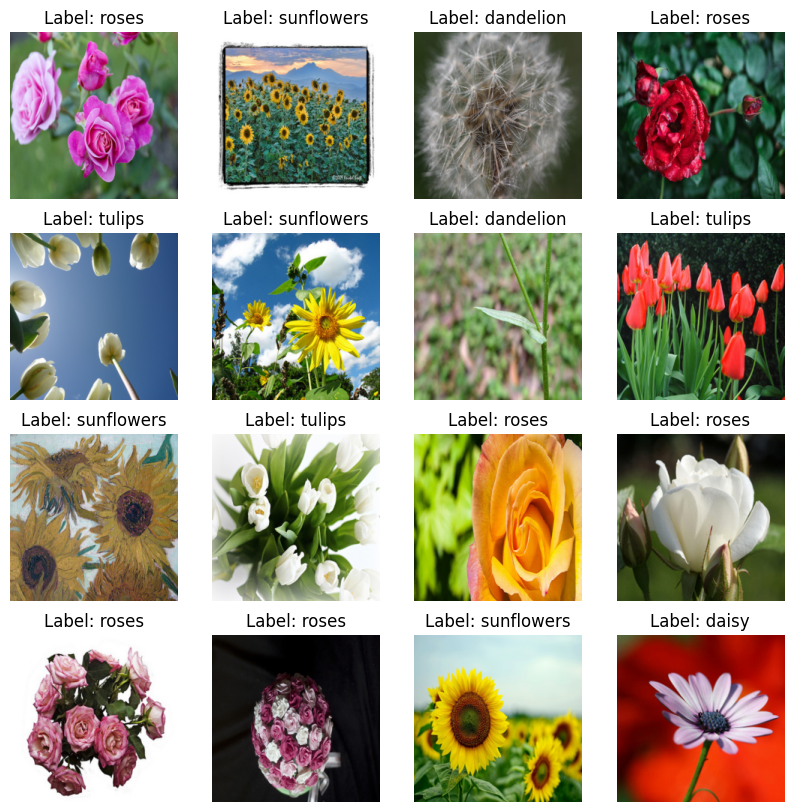

In [10]:
data_iterator=iter(train_loader)
images,labels=next(data_iterator)
print(images.shape)
print(labels.shape)
for image_batch, label_batch in data_iterator:
    fig,axs = plt.subplots(4,4, figsize=(10,10))
    for i in range(16):
      axs[i//4, i%4].imshow(image_batch[i].permute(1, 2, 0).numpy())
      axs[i//4, i%4].set_title(f"Label: {CLASS_NAMES[label_batch[i]]}")
      axs[i//4, i%4].axis('off')
    plt.show()
    break


In [14]:
EPOCH =4
LR = 0.001
Device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
#shallow neural network with no linera activation fuction and softmax output
class ShallowNeuralNetwork(nn.Module):
  def __init__(self,num_class):
    super(ShallowNeuralNetwork, self).__init__()
    self.flatten=nn.Flatten()
    self.hidden = nn.Linear(IMAGE_HEIGHT * IMAGE_WIDTH * IMAGE_RGB, num_class)

  def forward(self, x):
    # Flatten the image data in a better way
    x = self.flatten(x)
    x = self.hidden(x)
    return x


model=ShallowNeuralNetwork(len(CLASS_NAMES)).to(Device)

In [16]:
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

for epoch in range(EPOCH):
    # ---- Training ----
    model.train()
    running_loss = 0.0
    train_correct, train_total = 0, 0

    loop = tqdm(train_loader, leave=False, desc=f"Epoch {epoch+1}/{EPOCH}")
    for batch_idx, (images, labels) in enumerate(loop):
        images, labels = images.to(Device), labels.to(Device)

        optimizer.zero_grad()
        outputs = model(images)
        batch_loss = criterion(outputs, labels)
        batch_loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += batch_loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Running averages (like Keras)
        avg_loss = running_loss / (batch_idx + 1)
        avg_acc = 100.0 * train_correct / train_total
        loop.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{avg_acc:.2f}%")

    train_acc = 100.0 * train_correct / train_total

    # ---- Validation ----
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(Device), labels.to(Device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100.0 * val_correct / val_total
    avg_val_loss = val_loss / len(test_loader)

    # Epoch summary (Keras-like)
    print(f"Epoch [{epoch+1}/{EPOCH}] "
          f"Train Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Acc: {val_acc:.2f}%")



Epoch [1/4] Train Loss: 14.1502, Train Acc: 34.15%, Val Loss: 10.4403, Val Acc: 32.97%


Epoch [2/4] Train Loss: 9.7036, Train Acc: 42.30%, Val Loss: 15.3762, Val Acc: 33.51%


Epoch [3/4] Train Loss: 12.1595, Train Acc: 42.55%, Val Loss: 8.5565, Val Acc: 45.95%


Epoch [4/4] Train Loss: 8.8448, Train Acc: 48.85%, Val Loss: 9.0180, Val Acc: 43.51%


In [1]:
model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(Device), labels.to(Device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100.0 * val_correct / val_total
    avg_val_loss = val_loss / len(test_loader)

    # Epoch summary (Keras-like)
    print(f"Epoch [{epoch+1}/{EPOCH}] "
          f"Train Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Acc: {val_acc:.2f}%")


IndentationError: unexpected indent (ipython-input-3046573567.py, line 2)